# SCM.293 - Assignment II: 2E-LRP in Manhattan

## Load Packages


In [1]:
import sys
import numpy as np
import math
import random

import pandas as pd
import geopandas as gpd

import networkx as nx
import osmnx as ox


import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.spatial import distance
from haversine import haversine

import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

In [2]:
print(sys.version)

3.6.15 | packaged by conda-forge | (default, Dec  3 2021, 18:49:43) 
[GCC Clang 11.1.0]


## Define Classes

### Demand segments

In [3]:
class segment:
    """
    A class used to represent a customer segment
    
    Parameters
    ----------
    x : float
        the x-coordinate of segment centroid
    y : float
        the y-coordinate of segment centroid
    A : float
        segment area
    g : float
        average demand density
    q : float
        average dropsize
    d : demand
        total demand for the segment (parcels)
    k : float
        distance metric proportionality factor
    c : float
        average local circuity
    segment_ID : str
        a (preferrably unique) identifier of the segment

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the segment centroid
    type : str
        an identifier of the type of node the class represents (here: segment node)
    
    """
    
    def __init__(self,
                x,             
                y,
                A,
                g,
                q,
                d,
                k,
                c,
                segment_ID):

        
        self.x = x
        self.y = y
        self.loc = (self.x,self.y)
        self.A = float(A)
        self.g = float(g)
        self.q = float(q)
        self.d = float(d)
        
        self.k = float(k)
        self.c = float(c)
        self.segment_ID = str(segment_ID)
        self.type = 'segment'
        
        
        self.closestNetworkNode = None


### Depots

In [4]:
class depot:
    """
    A class used to represent a single depot node
    
    Parameters
    ----------
    x : float
        the x-coordinate of the depot location
    y : float
        the y-coordinate of the depot location
    F : float
        fixed cost of the depot
    Q: float
        capacity of the depot
    dep_type: str
        type of depot (hub or SF)
    dep_ID : str
        a (preferrably unique) identifier of the depot

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the depot
    type : str
        an identifier of the type of node the class represents (here: depot node)
    closestNetworkNode : ID (int)
        node ID of closest road network node - required for OSM mapping and distances
        default: None

    """
    
    def __init__(self,
                x,
                y,
                F,
                Q,
                dep_ID, 
                dep_type):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        
        self.F = float(F)
        self.Q = float(Q)
        self.dep_ID = str(dep_ID)
        self.dep_type = str(dep_type)
        
        self.type = 'depot'
        self.closestNetworkNode = None
                


### Second echelon vehicles

In [5]:
class second_echelon_vehicle_type:
    """
    A class used to represent a vehicle type operating at a second echelon (note: NOT an individual vehicle!)
    
    Parameters
    ----------
    Q : float
        carrying capacity of the vehicle type (e.g., in parcels)
    F : float
        fixed cost per vehicle of this vehicle type
    cd : float
        variable cost per distance for this vehicle type
    ch : float
        variable cost per time for this vehicle type
    Tm : float
        maximum allowed service time (per vehicle)
    td : float
        service time per stop
    ts : float
        route setup time
    sl : float
        linehaul speed
    s : float
        inter-stop speed
    vehtype_ID : str
        a (preferrably unique) identifier of the vehicle type
    
    """
    
    def __init__(self,
                Q,               
                F,               
                cd,
                ch,
                Tm,
                td,
                ts,
                sl,
                s,
                vehtype_ID):     
    
        self.Q = float(Q)
        self.F = float(F)
        self.cd = float(cd)
        self.ch = float(ch)
        
        self.Tm = float(Tm)
        self.td = float(td)
        self.ts = float(ts)
        self.sl = float(sl)
        self.s = float(s)
        
        self.vehtype_ID = str(vehtype_ID)
        
        

In [6]:
class first_echelon_vehicle:
    """
    A class used to represent a first echelon vehicle
    
    Parameters
    ----------
    Q : float
        carrying capacity of the vehicle type (e.g., in parcels)
    F : float
        fixed cost per vehicle of this vehicle type
    cd : float
        variable cost per distance for this vehicle type
    veh_type : str
        vehicle type
    vehtype_ID : str
        a (preferrably unique) identifier of the vehicle type
    
    """
    
    def __init__(self,
                Q,               
                F,               
                cd,
                veh_type,
                veh_ID):     
    
        self.Q = float(Q)
        self.F = float(F)
        self.cd = float(cd)
        self.veh_type = str(veh_type)
        self.veh_ID = str(veh_ID)
        
        

## Define Functions

Determine the node on a network that is closest to an arbitrary point

In [7]:
def closestNode(nodes, v, invDict):
    """
    nodes: array-like of node locations (tuples)
    v: point to test
    invDict: dictionary of node location to node ID
    ------
    Note to students: replacing haversine distance with Euclidean 
        distance and scipy.distance.cdist may be slightly more efficient.
        Distortion errors from using Euclidean probably acceptable here.
    """
    
    # Function that returns the location of the node that is closest to the point tested
    closest = min(nodes, key=lambda p: haversine(
            [v[0],v[1]],
            [p[0],p[1]])
            )

    # based on that location, return the ID of the closest node
    return invDict[closest]

Project arbitrary demand data (points of demand) to the closest nodes of an underlying road network

In [8]:
def projectDataOSM(point_data, graph, Save=False, filename=None):
    
    # create dictionary of node locations : node ID
    network_nodes = {}
    for n in graph.nodes.keys():
        network_nodes[(graph.nodes[n]['y'],graph.nodes[n]['x'])] = n
        
    # snap each point to nearest node (intersection) on road network
    
    nodes = []
    for index,row in tqdm(point_data.iterrows()):
        nodes.append(closestNode(network_nodes.keys(), (row.lat,row.lng), network_nodes))

    point_data['closest_nw_node'] = nodes
    
    # Save to file
    
    if Save==True:
        if filename == None:
            print('File name not specified.')
        else:
            point_data.to_csv(filename)

Map node data (zipcode centroids and depots) and (optional) arbitrary route data (trips on the network) to the underlying OSM road network

In [9]:
def mapDataOSM(demand_data, zipcode_data, depot_data, inactive_depot_data=pd.DataFrame(), snap_to_grid=True, route_data=None, route_colors='green', Plot=True):
       
    # get bounding box of customer locations
    
    ymax_cust = max(demand_data.lat.append(demand_data.lat))
    ymax_depot = max(depot_data.lat.append(depot_data.lat))
    ymax = max(ymax_cust, ymax_depot)
    print(ymax,'y max')
    
    ymin_cust = min(demand_data.lat.append(demand_data.lat))
    ymin_depot = min(depot_data.lat.append(depot_data.lat))
    ymin = min(ymin_cust, ymin_depot)
    print(ymin,'y min')
    
    xmax_cust = max(demand_data.lng.append(demand_data.lng))
    xmax_depot = max(depot_data.lng.append(depot_data.lng))
    xmax = max(xmax_cust, xmax_depot)
    print(xmax,'x max')
    
    xmin_cust = min(demand_data.lng.append(demand_data.lng))
    xmin_depot = min(depot_data.lng.append(depot_data.lng))
    xmin = min(xmin_cust, xmin_depot)
    print(xmin,'x min')
    
    # query OSMnx graph around extents of customer nodes
    
    g = ox.graph_from_bbox(
        ymax, ymin, xmax, xmin,
        network_type = 'drive',
        truncate_by_edge = True,
        clean_periphery = True
    )
       
    # snap each point to nearest node (intersection) on road network graph
    if snap_to_grid==True:
        projectDataOSM(zipcode_data, g)
        projectDataOSM(depot_data, g)
    else:
        print('Assuming nodes already projected on OSM graph.')

    
    # Plot on network
    
    if Plot==True:
        
        if route_data != None:
            
            fig, ax = ox.plot_graph_routes(g, 
                                           route_data, 
                                           figsize = (20,20),
                                           bgcolor = 'white',
                                           node_size=2, 
                                           node_alpha=0.5,
                                           edge_linewidth=0.3, 
                                           route_alpha=0.3,
                                           route_color = route_colors,
                                           orig_dest_node_color = 'green',
                                           orig_dest_node_size = 4.0,
                                           route_linewidth = 2.5,
                                           dpi=300, 
                                           show=False, close=False)
            
        else:

            fig, ax = ox.plot_graph(g, 
                                    figsize = (20,20),
                                    bgcolor = 'white',
                                    show=False, 
                                    close=False, 
                                    edge_alpha = 0.25, 
                                    node_alpha = 0)
            
            

        ax.scatter(zipcode_data.lng,
                       zipcode_data.lat,
                       alpha=0.5,
                       s=10*zipcode_data.Demand)
        
        
        hub_data = depot_data[depot_data.dep_type =="hub"]
        SF_data = depot_data[depot_data.dep_type =="SF"]
        
        ax.scatter(hub_data.lng,
           hub_data.lat,
           alpha=1.0,
           color='red',
           marker='v',
           s=200)
        
        ax.scatter(SF_data.lng,
           SF_data.lat,
           alpha=1.0,
           color='orange',
           marker='s',
           s=80)
        
        if not inactive_depot_data.empty:
            
            hub_data = inactive_depot_data[inactive_depot_data.dep_type =="hub"]
            SF_data = inactive_depot_data[inactive_depot_data.dep_type =="SF"]                        
            
            ax.scatter(hub_data.lng,
               hub_data.lat,
               alpha=1.0,
               color='gray',
               marker='v',
               s=200)
            
            ax.scatter(SF_data.lng,
               SF_data.lat,
               alpha=1.0,
               color='gray',
               marker='s',
               s=80)


        plt.show()
    
    return g, fig, ax

Calculate a distance between two nodes

In [10]:
def calc_dist(orig,dest,mode='Euclidian'):
    """
    Calculates a Euclidian distance

    Parameters
    ----------
    orig : customer or depot object
        origin node
    dest : customer or depot object
        destination node
    mode : string
        type of distance metric to use

    Returns
    -------
    dist : float
        Euclidian distance between origin and destination node
    """
    if mode == 'Euclidian':
        
        dist =  math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2) 
        
    elif mode == 'Haversine':
        
        dist = haversine([orig[0],orig[1]],[dest[0],dest[1]])
        
    else:
        
        dist = None
        print("Undefined distance metric.")
    
    return dist

Compute a pairwise distance matrix for a list of nodes

In [11]:
def d_matrix(nodes,g=None,mode='Euclidian',returnPaths=False):
    """
    Calculates a distance matrix

    Parameters
    ----------
    nodes : dict of customer or depot object
        all nodes (custoemrs, depots) in the network
    mode : str
        type of distance to use
        default value: Euclidian

    Returns
    -------
    dist_mat : dict 
        origin-destination matrix of distances
    """
    
    if mode == 'Euclidian' or mode == 'Haversine':
        dist_mat = dict(
            [((i,j),calc_dist(nodes[i].loc,nodes[j].loc,mode)) 
             for i in tqdm(nodes) for j in nodes]
            )
        path_mat = None
    elif mode == 'OSM':
        if g == None:
            dist_mat = {}
            print("Network information missing.")
        else:
            dist_mat = dict(
                [((i,j),nx.shortest_path_length(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode, weight='length')) 
                 for i in tqdm(nodes) for j in nodes]
            )
            
            
            if returnPaths == True:
                path_mat = dict(
                    [((i,j),nx.shortest_path(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode)) 
                     for i in tqdm(nodes) for j in nodes]
                )
            else:
                path_mat = None
            
            
    else: 
        dist_mat = {}
        path_mat = None
        print("Undefined distance metric.")
        
    return dist_mat, path_mat

In [12]:
def ARCE(segment, vehicle, depot, param, distances_OSM):
    
    """
    Calculates the augmented route cost estimation

    Parameters
    ----------
    segment : segment object
        segment in which vehicle routing is condisered 
    vehicle : vehicle object
        type of vehicle to be considered for routing
    depot : depot object
        depot from where distribution routes originate
    param: string
        name of parameter to be returned by the function ("h", "T_F", "T_c", "m", "n" or "f")
    
    Returns
    -------
    res : dict
        dictionnary containing total cost and all intermediate results
        
    """
    
    # Stops per route accounting for capacity only
    h = vehicle.Q / segment.q
    
    
    # Fixed duration of each route
    T_F = vehicle.ts + 2*(distances_OSM[(depot.dep_ID, segment.segment_ID)]/1000)/vehicle.sl
    
    
    # Variable duration per customer of each route
    T_c = segment.c * segment.k / (math.sqrt(segment.g) * vehicle.s) + vehicle.td
    
    
    # Effective number of stops per route
    if h*T_c + T_F <= vehicle.Tm:
        n = h
    else:
        n = (vehicle.Tm - T_F ) /T_c
    
    # Number of routes per vehicle per day
    if h*T_c + T_F <= vehicle.Tm:
        m = vehicle.Tm / (h*T_c + T_F )
    else:
        m = 1
    
    # Fleet size
    w = (segment.g * segment.A) / (n * m)
    
    
    # Fixed cost of vehicles
    f_F = vehicle.F * w
    
    # Distance-based cost of routes
    f_D = (vehicle.cd * w * m * (2* (distances_OSM[(depot.dep_ID, segment.segment_ID)]/1000) 
                                 + n * segment.k / math.sqrt(segment.g)))
           
         
    # Time-based cost of routes
    f_T = vehicle.ch * w * m * (vehicle.ts + 2*(distances_OSM[(depot.dep_ID, segment.segment_ID)]/1000) / vehicle.sl
                            + n * (vehicle.td + segment.c * segment.k / (math.sqrt(segment.g) * vehicle.s)))

    
    # Total cost of routes
    f = f_F + f_D + f_T
    
    res = {}
    res["h"] = h
    res["T_F"] = T_F
    res["T_c"] = T_c
    res["n"] = n
    res["m"] = m
    res["w"] = w
    
    res["f_F"] = f_F
    res["f_D"] = f_D
    res["f_T"] = f_T
    res["f"] = f
    
    return res[param]


## Initialize Problem

### Load Data

#### ZIP Codes

ZIP code shape files (obtained from NYC Open Data: https://data.cityofnewyork.us/widgets/i8iw-xf4u)

In [13]:
# Load an unpack shapefiles of NYC zip code boundaries
zipcode_gdf = gpd.read_file(f"zip://ZIP_CODE_040114.zip")

# Show data fields associated to these shape files
zipcode_gdf.dtypes

ZIPCODE         object
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [14]:
# Filter it down to only Manhattan and exclude certain zipcodes
zip_manhattan = zipcode_gdf[zipcode_gdf.PO_NAME=='New York']
zip_manhattan = zip_manhattan[zip_manhattan.ZIPCODE!='10004']
zip_manhattan = zip_manhattan[zip_manhattan.ZIPCODE!='10035']
zip_manhattan = zip_manhattan[zip_manhattan.ZIPCODE!='10034']
zip_manhattan = zip_manhattan[zip_manhattan.ZIPCODE!='10044']

#Keep only relevant columns
zip_manhattan = zip_manhattan[['ZIPCODE', 'geometry']]

# Project to Cartesian coordinate system with meters as unit
zip_manhattan = zip_manhattan.to_crs({'proj':'cea'})

# Calculate the area in square km
zip_manhattan['area_km2'] = zip_manhattan.geometry.apply(lambda x: x.area) / (1000 * 1000)

# Filter out very tiny (single-building) ZIP codes for clarity
zip_manhattan = zip_manhattan[zip_manhattan.area_km2>0.1]

#Project zipcode data to geodetic coordinate system to compute latitude and longitude of the zipcode centroid 
zip_manhattan = zip_manhattan.to_crs('EPSG:4326')
zip_manhattan['x'] = zip_manhattan.geometry.centroid.x
zip_manhattan['y'] = zip_manhattan.geometry.centroid.y

zip_manhattan['lng'] = zip_manhattan.geometry.centroid.x
zip_manhattan['lat'] = zip_manhattan.geometry.centroid.y


# Re-project to Cartesian coordinate system with meters as unit
zip_manhattan = zip_manhattan.to_crs({'proj':'cea'})

zip_manhattan.head()

/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Geometry is in a geographic 

,ZIPCODE,geometry,area_km2,x,y,lng,lat
22,10033,"POLYGON ((-8230087.206 4153458.716, -8230056.9...",1.500968,-73.936251,40.851094,-73.936251,40.851094
24,10040,"POLYGON ((-8230271.742 4152922.248, -8230258.6...",1.518126,-73.929119,40.858118,-73.929119,40.858118
32,10032,"POLYGON ((-8231733.069 4151867.638, -8231729.2...",2.151625,-73.941778,40.838955,-73.941778,40.838955
36,10031,"POLYGON ((-8230972.916 4150169.449, -8230939.5...",1.570283,-73.950048,40.824909,-73.950048,40.824909
37,10039,"POLYGON ((-8230339.288 4150653.631, -8230341.7...",0.782165,-73.937674,40.826666,-73.937674,40.826666


/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("OrRd"))
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

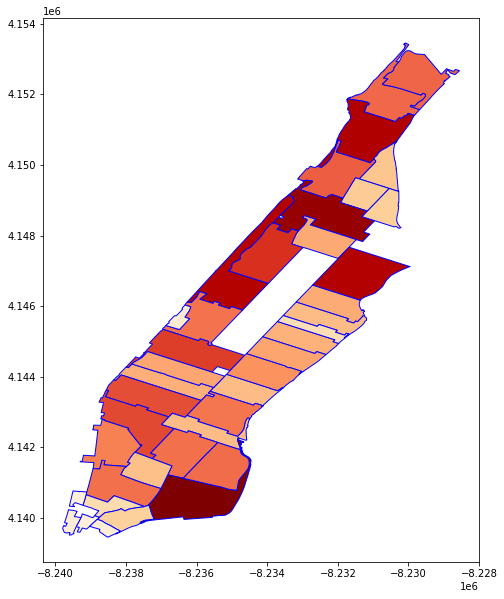

In [15]:
# Define custom color map
mycmapOrRd = plt.cm.OrRd
mycmapOrRd.set_under(color='gray')  


# Plot zipcodes according to their area
zip_manhattan.plot(column='area_km2', cmap=mycmapOrRd, vmin=0.0001, edgecolor='b', figsize=(10.0,10.0))

#### Demand Data

In [16]:
# load demand data 
demand = pd.read_csv('2022_SCM293_assignment2_NYC.csv')
data = demand

print(str(len(data))+' customers in the dataset.')

demand.head()


1671 customers in the dataset.


,CustomerID,lat,lng,delivery_zipcode,OrderSize
0,cust_0001,40.762750,-73.980883,10019,1
1,cust_0002,40.754552,-73.990854,10018,2
2,cust_0003,40.720388,-74.002408,10013,2
3,cust_0004,40.726019,-73.995445,10012,1
4,cust_0005,40.751727,-73.977451,10017,2


### Map Customer Stops to ZIP Codes

In [17]:
NStops = []
StopDensity = []
DropSize = []
Demand = []

# For each ZIP code in Manhattan
for index,row in tqdm(zip_manhattan.iterrows()):
    # Count the number of stops in that ZIP code
    NStops.append(len(data[data.delivery_zipcode==float(row.ZIPCODE)]))
    
    if len(data[data.delivery_zipcode==float(row.ZIPCODE)])>0:
        
        # Compute the stop density in that ZIP code
        StopDensity.append(len(data[data.delivery_zipcode==float(row.ZIPCODE)])/(zip_manhattan[zip_manhattan.ZIPCODE==row.ZIPCODE].area_km2.sum()))
  
        # Compute the average drop size in that ZIP code
        DropSize.append((data[data.delivery_zipcode==float(row.ZIPCODE)].OrderSize.sum())/len(data[data.delivery_zipcode==float(row.ZIPCODE)]))
        
        # Compute the total demand in that ZIP code
        Demand.append((data[data.delivery_zipcode==float(row.ZIPCODE)].OrderSize.sum()))

    else:
        StopDensity.append(0)
        DropSize.append(0)
        Demand.append(0)
        
# Write the number of stops, stop density, and drop size back to the data frame    
zip_manhattan['NStops'] = NStops
zip_manhattan['StopDensity'] = StopDensity
zip_manhattan['DropSize'] = DropSize
zip_manhattan['Demand'] = Demand

zip_manhattan.head()



40it [00:00, 70.75it/s]


,ZIPCODE,geometry,area_km2,x,y,lng,lat,NStops,StopDensity,DropSize,Demand
22,10033,"POLYGON ((-8230087.206 4153458.716, -8230056.9...",1.500968,-73.936251,40.851094,-73.936251,40.851094,1,0.666237,1.000000,1
24,10040,"POLYGON ((-8230271.742 4152922.248, -8230258.6...",1.518126,-73.929119,40.858118,-73.929119,40.858118,3,1.976121,1.333333,4
32,10032,"POLYGON ((-8231733.069 4151867.638, -8231729.2...",2.151625,-73.941778,40.838955,-73.941778,40.838955,4,1.859060,1.500000,6
36,10031,"POLYGON ((-8230972.916 4150169.449, -8230939.5...",1.570283,-73.950048,40.824909,-73.950048,40.824909,0,0.000000,0.000000,0
37,10039,"POLYGON ((-8230339.288 4150653.631, -8230341.7...",0.782165,-73.937674,40.826666,-73.937674,40.826666,0,0.000000,0.000000,0


<AxesSubplot:>

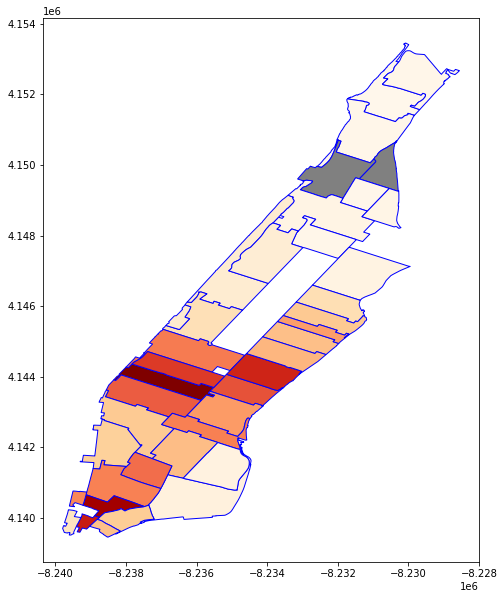

In [18]:
# Plot ZIP codes and color by stop density
zip_manhattan.plot(column='StopDensity', cmap=mycmapOrRd, vmin=0.0001, edgecolor='b', figsize=(10.0,10.0))

### Create Objects

#### ZIP Codes as Demand Segments

Create dictionary of demand segments

In [19]:
segments = dict(
[(z, segment(
        x=zip_manhattan[zip_manhattan.ZIPCODE==z].geometry.centroid.x.mean(),
        y=zip_manhattan[zip_manhattan.ZIPCODE==z].geometry.centroid.y.mean(),
        A = zip_manhattan[zip_manhattan.ZIPCODE==z].area_km2.mean(),
        k=0.57, # Daganzo (1994) L2 norm VRP
        c=random.uniform(2.2,3.5),
        g = zip_manhattan[zip_manhattan.ZIPCODE==z].StopDensity.mean(),
        q = zip_manhattan[zip_manhattan.ZIPCODE==z].DropSize.mean(),
        d = zip_manhattan[zip_manhattan.ZIPCODE==z].Demand.mean(),
        segment_ID=str(z)))
 for z in zip_manhattan.ZIPCODE.unique()
])

print(str(len(segments))+' demand segments created.')

40 demand segments created.


Keep only segments with positive demand

In [20]:
active_segments = {k:segments[k] for k in segments if segments[k].d >0}
print(str(len(active_segments))+' active demand segments.')        

38 active demand segments.


#### Depot

Load depot data

In [21]:
# load depot data 
dep_locs = pd.read_csv('2022_SCM293_assignment2_depots.csv')
dep_locs

,DepotID,lat,lng,capacity,fixed_cost,dep_type
0,hub01,40.814928,-73.924258,3000,1000,hub
1,hub02,40.848179,-73.971980,3000,1000,hub
2,hub03,40.854152,-73.929408,3000,1000,hub
3,SF001,40.715974,-73.986576,1000,400,SF
4,SF002,40.746109,-73.950401,1000,400,SF
5,SF003,40.755563,-74.003533,1000,400,SF
6,SF004,40.733659,-73.980893,1000,400,SF
7,SF005,40.782077,-73.979278,1000,400,SF
8,SF006,40.797144,-73.961191,1000,400,SF
9,SF007,40.813843,-73.918715,1000,400,SF


Create dictionnary of depot objects

In [22]:
# All depots
depots = dict([
    (dep_locs.loc[i].DepotID,
     depot(x=dep_locs.lat.iloc[i],
           y=dep_locs.lng.iloc[i],
           dep_ID=dep_locs.DepotID.iloc[i],
           dep_type=dep_locs.dep_type.iloc[i],
           Q = dep_locs.capacity.iloc[i],
           F=dep_locs.fixed_cost.iloc[i])) for i in range(len(dep_locs))
])

print(str(len(depots))+' depots in total created.')        

# Hubs
hubs = {k:depots[k] for k in depots if depots[k].dep_type =="hub"}
print(str(len(hubs))+' hubs created.')        

# Satellite facilities
SFs = {k:depots[k] for k in depots if depots[k].dep_type =="SF"}
print(str(len(SFs))+' satellite facilities created.')        


11 depots in total created.
3 hubs created.
8 satellite facilities created.


### Project Zipcode Centroids and Depot Nodes on OSM Road Network and Plot

Without Route Information

40.8625608 y max
40.70373729999999 y min
-73.918715 x max
-74.0185571 x min


/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
40it [00:00, 60.78it/s]
11it [00:00

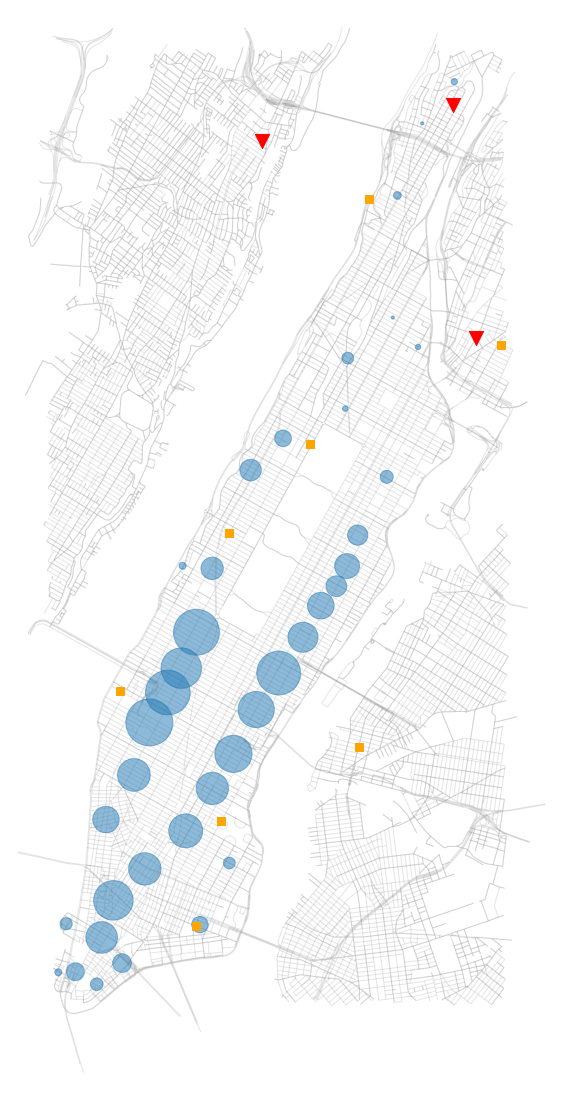

In [23]:
myg_segments, fig, ax= mapDataOSM(data,zip_manhattan,dep_locs)

Assign closest network nodes to depots and demand segment centroids

In [24]:
for i in depots:
    depots[i].closestNetworkNode = int(dep_locs[dep_locs.DepotID==i].closest_nw_node)
    
for i in segments:
    segments[i].closestNetworkNode = int(zip_manhattan[zip_manhattan.ZIPCODE==i].closest_nw_node)    

#### Vehicle objects

Load data on second echelon vehicle types


In [25]:
# load depot data 
veh_2nd_echelon_data = pd.read_csv('2022_SCM293_assignment2_2ndE_vehtypes.csv')
veh_2nd_echelon_data


,veh_type,capacity,c_fixed,c_distance,c_time,speed_inter_stop,speed_linaul,service_time,route_setup_time,max_time
0,van,50,100,0.5,40,15,20,0.1,0.5,10
1,bike,15,25,0.1,30,7,10,0.1,0.3,10


Create dictionnary of second echelon vehicle type objects

In [26]:
second_echelon_vehicle_types = dict([
    (veh_2nd_echelon_data.loc[i].veh_type,
     second_echelon_vehicle_type(
         Q=veh_2nd_echelon_data.capacity.iloc[i],
         F=veh_2nd_echelon_data.c_fixed.iloc[i],
         cd=veh_2nd_echelon_data.c_distance.iloc[i],
         ch=veh_2nd_echelon_data.c_time.iloc[i],
         Tm=veh_2nd_echelon_data.max_time.iloc[i],
         td=veh_2nd_echelon_data.service_time.iloc[i],
         ts=veh_2nd_echelon_data.route_setup_time.iloc[i],
         sl=veh_2nd_echelon_data.speed_linaul.iloc[i],
         s=veh_2nd_echelon_data.speed_inter_stop.iloc[i],         
         vehtype_ID=veh_2nd_echelon_data.veh_type.iloc[i])) for i in range(len(veh_2nd_echelon_data)) ])

print(str(len(second_echelon_vehicle_types))+' second echelon vehicle types created.')        


2 second echelon vehicle types created.


Load data on first echelon vehicles

In [27]:
veh_1st_echelon_data = pd.read_csv('2022_SCM293_assignment2_1stE_vehicles.csv')
veh_1st_echelon_data

,veh_ID,veh_type,capacity,c_fixed,c_distance
0,V_1,truck,250,200,1
1,V_2,truck,250,200,1
2,V_3,truck,250,200,1
3,V_4,truck,250,200,1
4,V_5,truck,250,200,1
5,V_6,truck,250,200,1
6,V_7,truck,250,200,1
7,V_8,truck,250,200,1
8,V_9,truck,250,200,1
9,V_10,truck,250,200,1


Create dictionnary of first echelon vehicles

In [28]:
first_echelon_vehicles = dict([
    (veh_1st_echelon_data.loc[i].veh_ID,
     first_echelon_vehicle(
         Q=veh_1st_echelon_data.capacity.iloc[i],
         F=veh_1st_echelon_data.c_fixed.iloc[i],
         cd=veh_1st_echelon_data.c_distance.iloc[i],
         veh_type=veh_1st_echelon_data.veh_type.iloc[i],
         veh_ID=veh_1st_echelon_data.veh_ID.iloc[i])) for i in range(len(veh_1st_echelon_data))])

print(str(len(first_echelon_vehicles))+' first echelon vehicles created.')        


20 first echelon vehicles created.


### Calculate Distance Matrix

Define set of all nodes

In [29]:
nodes = {**depots, **segments}

Calculate distances

In [30]:
distances_OSM, paths_OSM = d_matrix(nodes,myg_segments,mode='OSM',returnPaths=True)

100%|██████████| 51/51 [00:02<00:00, 21.22it/s]


Use OSM distances moving forward

In [31]:
distances = distances_OSM

# Part 1: Two-echelon distribution network
    

In [32]:
m = gp.Model('Problem_1')

#Variables
r = dict(
    [((i,j,t), m.addVar(vtype=GRB.BINARY, name=f"r_{i}_{j}^{t}")) 
     for i in depots
     for j in depots
     for t in first_echelon_vehicles]
)
x = dict(
    [((i,j,v), m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}^{v}")) 
     for i in active_segments
     for j in depots
     for v in second_echelon_vehicle_types]
)
w = dict(
    [((z,s), m.addVar(vtype=GRB.BINARY, name=f"w_{z}_{s}")) 
     for z in active_segments
     for s in depots]
)
y = dict(
    [((s), m.addVar(vtype=GRB.BINARY, name=f"y_{s}")) 
     for s in depots]
)
u = dict(
    [((t), m.addVar(vtype=GRB.BINARY, name=f"u_{t}")) 
     for t in first_echelon_vehicles]
)
f = dict(
    [((p,s,t), m.addVar(vtype=GRB.CONTINUOUS, name=f"f_{p}_{s}^{t}")) 
     for p in hubs
     for s in SFs
     for t in first_echelon_vehicles]
)
L = dict(
    [((s), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, ub=float('inf'), name=f"L_{s}")) 
     for s in depots]
)

m.setObjective(
    quicksum([depots[p].F*y[p] for p in depots])+
    quicksum([first_echelon_vehicles[t].F*u[t] for t in first_echelon_vehicles])+
    quicksum([r[(i,j,t)]*((1/1000)*distances[(i,j)])*first_echelon_vehicles[t].cd 
             for i in depots for j in depots for t in first_echelon_vehicles])+
    quicksum([ARCE(active_segments[s],second_echelon_vehicle_types[v],depots[p],'f',distances)*x[(s,p,v)] 
             for s in active_segments for p in depots for v in second_echelon_vehicle_types])
               ,GRB.MINIMIZE)

constraint_2 = dict(
    [((z),m.addConstr(quicksum([x[(z,j,v)] for v in second_echelon_vehicle_types for j in depots])==1,
    f"constraint2_{z}"))
    for z in active_segments]
)

constraint_6ish_1 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])>=y[(l)],
    f"constraint6ish_1_{l}")) 
     for l in SFs]
)

constraint_6ish_2 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])<=
                      y[(l)]*len(first_echelon_vehicles),
    f"constraint6ish_2_{l}")) 
     for l in SFs]
)

constraint_7 = dict(
    [((h,t),m.addConstr(quicksum([r[(l,h,t)] for l in depots])-quicksum([r[(h,l,t)] for l in depots])==0,
    f"constraint7_{h}^{t}")) 
     for h in depots
     for t in first_echelon_vehicles]
)

constraint_8 = dict(
    [((i,j),m.addConstr(L[(i)]-L[(j)]+quicksum(r[(i,j,t)]*len(depots) for t in first_echelon_vehicles)<=
                        (len(depots)-1),
    f"constraint8_{i}_{j}")) 
     for i in SFs
     for j in SFs 
     if i != j]
)

constraint_9 = dict(
    [((t),m.addConstr(quicksum([r[(l,j,t)] for l in depots for j in hubs])<=1,
    "constraint9^{t}")) 
     for t in first_echelon_vehicles]
)


constraint_10 = dict(
    [((z,v,s), m.addConstr(x[(z,s,v)]<=w[(z,s)],
    "constraint_10_{z_v_s}"))
     for z in active_segments
     for v in second_echelon_vehicle_types
     for s in depots]
)

constraint_11 = dict(
    [((z),m.addConstr(quicksum([w[(z,s)] for s in depots])==1,
    f"constraint11_{z}")) 
     for z in active_segments]
)

constraint_12 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            quicksum([active_segments[z].d*w[(z,s)] for z in active_segments])==0,
    "constraint12_{s}")) 
     for s in SFs]
)

constraint_13 = dict(
    [((p),m.addConstr(quicksum([f[(p,s,t)] for s in SFs for t in first_echelon_vehicles])+
            quicksum([x[(z,p,v)]*segments[z].d for z in active_segments for v in second_echelon_vehicle_types])-
            depots[p].Q * y[(p)]<=0,
    f"constraint13_{p}")) 
     for p in hubs]
)

constraint_14 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            depots[s].Q*y[(s)]<=0,
    f"constraint14_{s}")) 
     for s in SFs]
)

constraint_15 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(s,h,t)] for h in depots])-f[(p,s,t)]>=0,
    f"constraint15_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_16 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(p,h,t)] for h in depots])-f[(p,s,t)]>=0, 
    f"constraint16_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_18 = dict(
    [((t),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for s in SFs])<=first_echelon_vehicles[t].Q*u[(t)],
    f"constraint18^{t}")) 
     for t in first_echelon_vehicles]
)

constraint_added1 = dict(
    [((z,p),m.addConstr(w[(z,p)]<=y[p], 
    f"constraint_added1_{p}_{z}")) 
     for z in active_segments
     for p in depots]
)

constraint_added2 = dict(
    [((i,j,t),m.addConstr(r[(i,j,t)]==0, 
    f"constraint_added2_{i}_{j}_{t}")) 
     for i in hubs
     for j in hubs
     for t in first_echelon_vehicles]
)


constraint_added3 = dict(
    [((z,h),m.addConstr(w[(z,h)] == 0,
    f"constraint_added3_{z}_{h}" )) 
     for z in active_segments
     for h in hubs]
)

m.reset()
m.update()
m.Params.MIPGap = 0.0025 
m.Params.timelimit = 3600
m.optimize()


Academic license - for non-commercial use only - expires 2022-08-19
Using license file /Users/bennetthellman/gurobi.lic
Discarded solution information
Changed value of parameter MIPGap to 0.0025
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2935 rows, 4196 columns and 27887 nonzeros
Model fingerprint: 0x0dd37fc1
Variable types: 491 continuous, 3705 integer (3705 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [6e-01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 1282 rows and 1133 columns
Presolve time: 0.06s
Presolved: 1653 rows, 3063 columns, 21815 nonzeros
Variable types: 488 continuous, 2575 integer (2575 binary)

Root relaxation: objective 1.547969e+

In [33]:
h_ffc = 0
for i in hubs:
    h_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of hubs = ${h_ffc:.2f}')

sf_ffc = 0
for i in SFs:
    sf_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of SFs = ${sf_ffc:.2f}')

cost_one_vec = 0
for i in first_echelon_vehicles:
    cost_one_vec+=round(u[i].x)*round(first_echelon_vehicles[i].F)
    for j in depots:
        for k in depots:
            cost_one_vec+=round(r[(j,k,i)].x)*(1/1000)*distances[(j,k)]*first_echelon_vehicles[i].cd
print(f'Cost of first echelon transportation = ${cost_one_vec:.2f}')

cost_two_vec = 0
for i in second_echelon_vehicle_types:
    for j in depots:
        for k in active_segments:
            cost_two_vec+=round(x[(k,j,i)].x)*ARCE(active_segments[k],
                    second_echelon_vehicle_types[i],depots[j],'f',distances)
print(f'Cost of second echelon transportation = ${cost_two_vec:.2f}')

ahubs = 0
for i in hubs:
    ahubs+=y[i].x
print(f'Number of hubs activated = {round(ahubs)}')

sat_facs = 0
for i in SFs:
    sat_facs+=y[i].x
print(f'Number of satellite facilities activated = {sat_facs}')

one_vecs = 0
for i in first_echelon_vehicles:
    one_vecs+=u[i].x
print(f'Number of first echelon vehicles employed = {round(one_vecs)}')

cdpv = 0
for i in active_segments:
    for j in depots:
        cdpv+=segments[i].d*round(x[i,j,'van'].x)
print(f'Total customer demand (parcels) served through vans = {cdpv}')

cdpb = 0
for i in active_segments:
    for j in depots:
        cdpb+=segments[i].d*round(x[i,j,'bike'].x)
print(f'Total customer demand (parcels) served through bikes = {cdpb}')

cdph = 0
for i in active_segments:
    for j in hubs:
        for k in second_echelon_vehicle_types:
            cdph+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through hubs = {cdph}')

cdpsf = 0
for i in active_segments:
    for j in SFs:
        for k in second_echelon_vehicle_types:
            cdpsf+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through SFs = {cdpsf}')

Fixed facility cost of hubs = $1000.00
Fixed facility cost of SFs = $1200.00
Cost of first echelon transportation = $2366.35
Cost of second echelon transportation = $11273.93
Number of hubs activated = 1
Number of satellite facilities activated = 3.0
Number of first echelon vehicles employed = 11
Total customer demand (parcels) served through vans = 1135.0
Total customer demand (parcels) served through bikes = 1508.0
Total customer demand (parcels) served through hubs = 0.0
Total customer demand (parcels) served through SFs = 2643.0


# Part 2: Mixed two-echelon distribution network
    

In [34]:
m = gp.Model('Problem_2')

#Variables
r = dict(
    [((i,j,t), m.addVar(vtype=GRB.BINARY, name=f"r_{i}_{j}^{t}")) 
     for i in depots
     for j in depots
     for t in first_echelon_vehicles]
)
x = dict(
    [((i,j,v), m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}^{v}")) 
     for i in active_segments
     for j in depots
     for v in second_echelon_vehicle_types]
)
w = dict(
    [((z,s), m.addVar(vtype=GRB.BINARY, name=f"w_{z}_{s}")) 
     for z in active_segments
     for s in depots]
)
y = dict(
    [((s), m.addVar(vtype=GRB.BINARY, name=f"y_{s}")) 
     for s in depots]
)
u = dict(
    [((t), m.addVar(vtype=GRB.BINARY, name=f"u_{t}")) 
     for t in first_echelon_vehicles]
)
f = dict(
    [((p,s,t), m.addVar(vtype=GRB.CONTINUOUS, name=f"f_{p}_{s}^{t}")) 
     for p in hubs
     for s in SFs
     for t in first_echelon_vehicles]
)
L = dict(
    [((s), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, ub=float('inf'), name=f"L_{s}")) 
     for s in depots]
)

m.setObjective(
    quicksum([depots[p].F*y[p] for p in depots])+
    quicksum([first_echelon_vehicles[t].F*u[t] for t in first_echelon_vehicles])+
    quicksum([r[(i,j,t)]*((1/1000)*distances[(i,j)])*first_echelon_vehicles[t].cd 
             for i in depots for j in depots for t in first_echelon_vehicles])+
    quicksum([ARCE(active_segments[s],second_echelon_vehicle_types[v],depots[p],'f',distances)*x[(s,p,v)] 
             for s in active_segments for p in depots for v in second_echelon_vehicle_types])
               ,GRB.MINIMIZE)

constraint_2 = dict(
    [((z),m.addConstr(quicksum([x[(z,j,v)] for v in second_echelon_vehicle_types for j in depots])==1,
    f"constraint2_{z}"))
    for z in active_segments]
)

constraint_6ish_1 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])>=y[(l)],
    f"constraint6ish_1_{l}")) 
     for l in SFs]
)

constraint_6ish_2 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])<=
                      y[(l)]*len(first_echelon_vehicles),
    f"constraint6ish_2_{l}")) 
     for l in SFs]
)

constraint_7 = dict(
    [((h,t),m.addConstr(quicksum([r[(l,h,t)] for l in depots])-quicksum([r[(h,l,t)] for l in depots])==0,
    f"constraint7_{h}^{t}")) 
     for h in depots
     for t in first_echelon_vehicles]
)

constraint_8 = dict(
    [((i,j),m.addConstr(L[(i)]-L[(j)]+quicksum(r[(i,j,t)]*len(depots) for t in first_echelon_vehicles)<=
                        (len(depots)-1),
    f"constraint8_{i}_{j}")) 
     for i in SFs
     for j in SFs 
     if i != j]
)

constraint_9 = dict(
    [((t),m.addConstr(quicksum([r[(l,j,t)] for l in depots for j in hubs])<=1,
    "constraint9^{t}")) 
     for t in first_echelon_vehicles]
)


constraint_10 = dict(
    [((z,v,s), m.addConstr(x[(z,s,v)]<=w[(z,s)],
    "constraint_10_{z_v_s}"))
     for z in active_segments
     for v in second_echelon_vehicle_types
     for s in depots]
)

constraint_11 = dict(
    [((z),m.addConstr(quicksum([w[(z,s)] for s in depots])==1,
    f"constraint11_{z}")) 
     for z in active_segments]
)

constraint_12 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            quicksum([active_segments[z].d*w[(z,s)] for z in active_segments])==0,
    "constraint12_{s}")) 
     for s in SFs]
)

constraint_13 = dict(
    [((p),m.addConstr(quicksum([f[(p,s,t)] for s in SFs for t in first_echelon_vehicles])+
            quicksum([x[(z,p,v)]*segments[z].d for z in active_segments for v in second_echelon_vehicle_types])-
            depots[p].Q * y[(p)]<=0,
    f"constraint13_{p}")) 
     for p in hubs]
)

constraint_14 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            depots[s].Q*y[(s)]<=0,
    f"constraint14_{s}")) 
     for s in SFs]
)

constraint_15 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(s,h,t)] for h in depots])-f[(p,s,t)]>=0,
    f"constraint15_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_16 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(p,h,t)] for h in depots])-f[(p,s,t)]>=0, 
    f"constraint16_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_18 = dict(
    [((t),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for s in SFs])<=first_echelon_vehicles[t].Q*u[(t)],
    f"constraint18^{t}")) 
     for t in first_echelon_vehicles]
)

constraint_added1 = dict(
    [((z,p),m.addConstr(w[(z,p)]<=y[p], 
    f"constraint_added1_{p}_{z}")) 
     for z in active_segments
     for p in depots]
)

constraint_added2 = dict(
    [((i,j,t),m.addConstr(r[(i,j,t)]==0, 
    f"constraint_added2_{i}_{j}_{t}")) 
     for i in hubs
     for j in hubs
     for t in first_echelon_vehicles]
)

m.reset()
m.update()
m.Params.MIPGap = 0.0025 
m.Params.timelimit = 3600
m.optimize()

Discarded solution information
Changed value of parameter MIPGap to 0.0025
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2821 rows, 4196 columns and 27773 nonzeros
Model fingerprint: 0x9db35484
Variable types: 491 continuous, 3705 integer (3705 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [6e-01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 25515.642022
Presolve removed 1054 rows and 1019 columns
Presolve time: 0.06s
Presolved: 1767 rows, 3177 columns, 22271 nonzeros
Found heuristic solution: objective 16485.258784
Variable types: 488 continuous, 2689 integer (2689 binary)

Root relaxation: objective 1.492246e+04, 1530 iterations, 0

In [35]:
h_ffc = 0
for i in hubs:
    h_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of hubs = ${h_ffc:.2f}')

sf_ffc = 0
for i in SFs:
    sf_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of SFs = ${sf_ffc:.2f}')

cost_one_vec = 0
for i in first_echelon_vehicles:
    cost_one_vec+=round(u[i].x)*round(first_echelon_vehicles[i].F)
    for j in depots:
        for k in depots:
            cost_one_vec+=round(r[(j,k,i)].x)*(1/1000)*distances[(j,k)]*first_echelon_vehicles[i].cd
print(f'Cost of first echelon transportation = ${cost_one_vec:.2f}')

cost_two_vec = 0
for i in second_echelon_vehicle_types:
    for j in depots:
        for k in active_segments:
            cost_two_vec+=round(x[(k,j,i)].x)*ARCE(active_segments[k],
                    second_echelon_vehicle_types[i],depots[j],'f',distances)
print(f'Cost of second echelon transportation = ${cost_two_vec:.2f}')

ahubs = 0
for i in hubs:
    ahubs+=y[i].x
print(f'Number of hubs activated = {round(ahubs)}')

sat_facs = 0
for i in SFs:
    sat_facs+=y[i].x
print(f'Number of satellite facilities activated = {sat_facs}')

one_vecs = 0
for i in first_echelon_vehicles:
    one_vecs+=u[i].x
print(f'Number of first echelon vehicles employed = {round(one_vecs)}')

cdpv = 0
for i in active_segments:
    for j in depots:
        cdpv+=segments[i].d*round(x[i,j,'van'].x)
print(f'Total customer demand (parcels) served through vans = {cdpv}')

cdpb = 0
for i in active_segments:
    for j in depots:
        cdpb+=segments[i].d*round(x[i,j,'bike'].x)
print(f'Total customer demand (parcels) served through bikes = {cdpb}')

cdph = 0
for i in active_segments:
    for j in hubs:
        for k in second_echelon_vehicle_types:
            cdph+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through hubs = {cdph}')

cdpsf = 0
for i in active_segments:
    for j in SFs:
        for k in second_echelon_vehicle_types:
            cdpsf+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through SFs = {cdpsf}')

Fixed facility cost of hubs = $1000.00
Fixed facility cost of SFs = $400.00
Cost of first echelon transportation = $892.73
Cost of second echelon transportation = $12731.50
Number of hubs activated = 1
Number of satellite facilities activated = 1.0
Number of first echelon vehicles employed = 4
Total customer demand (parcels) served through vans = 1951.0
Total customer demand (parcels) served through bikes = 692.0
Total customer demand (parcels) served through hubs = 1643.0
Total customer demand (parcels) served through SFs = 1000.0


# Part 3: Mixed two-echelon distribution network with service time constraints
    

In [36]:
#Your code here
for t in second_echelon_vehicle_types:
    second_echelon_vehicle_types[t].Tm = 5

## With pure-play:

In [37]:
m = gp.Model('Problem_3')

#Variables
r = dict(
    [((i,j,t), m.addVar(vtype=GRB.BINARY, name=f"r_{i}_{j}^{t}")) 
     for i in depots
     for j in depots
     for t in first_echelon_vehicles]
)
x = dict(
    [((i,j,v), m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}^{v}")) 
     for i in active_segments
     for j in depots
     for v in second_echelon_vehicle_types]
)
w = dict(
    [((z,s), m.addVar(vtype=GRB.BINARY, name=f"w_{z}_{s}")) 
     for z in active_segments
     for s in depots]
)
y = dict(
    [((s), m.addVar(vtype=GRB.BINARY, name=f"y_{s}")) 
     for s in depots]
)
u = dict(
    [((t), m.addVar(vtype=GRB.BINARY, name=f"u_{t}")) 
     for t in first_echelon_vehicles]
)
f = dict(
    [((p,s,t), m.addVar(vtype=GRB.CONTINUOUS, name=f"f_{p}_{s}^{t}")) 
     for p in hubs
     for s in SFs
     for t in first_echelon_vehicles]
)
L = dict(
    [((s), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, ub=float('inf'), name=f"L_{s}")) 
     for s in depots]
)

m.setObjective(
    quicksum([depots[p].F*y[p] for p in depots])+
    quicksum([first_echelon_vehicles[t].F*u[t] for t in first_echelon_vehicles])+
    quicksum([r[(i,j,t)]*((1/1000)*distances[(i,j)])*first_echelon_vehicles[t].cd 
             for i in depots for j in depots for t in first_echelon_vehicles])+
    quicksum([ARCE(active_segments[s],second_echelon_vehicle_types[v],depots[p],'f',distances)*x[(s,p,v)] 
             for s in active_segments for p in depots for v in second_echelon_vehicle_types])
               ,GRB.MINIMIZE)

constraint_2 = dict(
    [((z),m.addConstr(quicksum([x[(z,j,v)] for v in second_echelon_vehicle_types for j in depots])==1,
    f"constraint2_{z}"))
    for z in active_segments]
)

constraint_6ish_1 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])>=y[(l)],
    f"constraint6ish_1_{l}")) 
     for l in SFs]
)

constraint_6ish_2 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])<=
                      y[(l)]*len(first_echelon_vehicles),
    f"constraint6ish_2_{l}")) 
     for l in SFs]
)

constraint_7 = dict(
    [((h,t),m.addConstr(quicksum([r[(l,h,t)] for l in depots])-quicksum([r[(h,l,t)] for l in depots])==0,
    f"constraint7_{h}^{t}")) 
     for h in depots
     for t in first_echelon_vehicles]
)

constraint_8 = dict(
    [((i,j),m.addConstr(L[(i)]-L[(j)]+quicksum(r[(i,j,t)]*len(depots) for t in first_echelon_vehicles)<=
                        (len(depots)-1),
    f"constraint8_{i}_{j}")) 
     for i in SFs
     for j in SFs 
     if i != j]
)

constraint_9 = dict(
    [((t),m.addConstr(quicksum([r[(l,j,t)] for l in depots for j in hubs])<=1,
    "constraint9^{t}")) 
     for t in first_echelon_vehicles]
)


constraint_10 = dict(
    [((z,v,s), m.addConstr(x[(z,s,v)]<=w[(z,s)],
    "constraint_10_{z_v_s}"))
     for z in active_segments
     for v in second_echelon_vehicle_types
     for s in depots]
)

constraint_11 = dict(
    [((z),m.addConstr(quicksum([w[(z,s)] for s in depots])==1,
    f"constraint11_{z}")) 
     for z in active_segments]
)

constraint_12 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            quicksum([active_segments[z].d*w[(z,s)] for z in active_segments])==0,
    "constraint12_{s}")) 
     for s in SFs]
)

constraint_13 = dict(
    [((p),m.addConstr(quicksum([f[(p,s,t)] for s in SFs for t in first_echelon_vehicles])+
            quicksum([x[(z,p,v)]*segments[z].d for z in active_segments for v in second_echelon_vehicle_types])-
            depots[p].Q * y[(p)]<=0,
    f"constraint13_{p}")) 
     for p in hubs]
)

constraint_14 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            depots[s].Q*y[(s)]<=0,
    f"constraint14_{s}")) 
     for s in SFs]
)

constraint_15 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(s,h,t)] for h in depots])-f[(p,s,t)]>=0,
    f"constraint15_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_16 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(p,h,t)] for h in depots])-f[(p,s,t)]>=0, 
    f"constraint16_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_18 = dict(
    [((t),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for s in SFs])<=first_echelon_vehicles[t].Q*u[(t)],
    f"constraint18^{t}")) 
     for t in first_echelon_vehicles]
)

constraint_added1 = dict(
    [((z,p),m.addConstr(w[(z,p)]<=y[p], 
    f"constraint_added1_{p}_{z}")) 
     for z in active_segments
     for p in depots]
)

constraint_added2 = dict(
    [((i,j,t),m.addConstr(r[(i,j,t)]==0, 
    f"constraint_added2_{i}_{j}_{t}")) 
     for i in hubs
     for j in hubs
     for t in first_echelon_vehicles]
)

constraint_added3 = dict(
    [((z,h),m.addConstr(w[(z,h)] == 0,
    f"constraint_added3_{z}_{h}" )) 
     for z in active_segments
     for h in hubs]
)

m.reset()
m.update()
m.Params.MIPGap = 0.0025 
m.Params.timelimit = 3600
m.optimize()

Discarded solution information
Changed value of parameter MIPGap to 0.0025
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2935 rows, 4196 columns and 27887 nonzeros
Model fingerprint: 0x250956cc
Variable types: 491 continuous, 3705 integer (3705 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [6e-01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 1282 rows and 1133 columns
Presolve time: 0.05s
Presolved: 1653 rows, 3063 columns, 21815 nonzeros
Variable types: 488 continuous, 2575 integer (2575 binary)

Root relaxation: objective 1.678499e+04, 1134 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl

In [38]:
h_ffc = 0
for i in hubs:
    h_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of hubs = ${h_ffc:.2f}')

sf_ffc = 0
for i in SFs:
    sf_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of SFs = ${sf_ffc:.2f}')

cost_one_vec = 0
for i in first_echelon_vehicles:
    cost_one_vec+=round(u[i].x)*round(first_echelon_vehicles[i].F)
    for j in depots:
        for k in depots:
            cost_one_vec+=round(r[(j,k,i)].x)*(1/1000)*distances[(j,k)]*first_echelon_vehicles[i].cd
print(f'Cost of first echelon transportation = ${cost_one_vec:.2f}')

cost_two_vec = 0
for i in second_echelon_vehicle_types:
    for j in depots:
        for k in active_segments:
            cost_two_vec+=round(x[(k,j,i)].x)*ARCE(active_segments[k],
                    second_echelon_vehicle_types[i],depots[j],'f',distances)
print(f'Cost of second echelon transportation = ${cost_two_vec:.2f}')

ahubs = 0
for i in hubs:
    ahubs+=y[i].x
print(f'Number of hubs activated = {round(ahubs)}')

sat_facs = 0
for i in SFs:
    sat_facs+=y[i].x
print(f'Number of satellite facilities activated = {sat_facs}')

one_vecs = 0
for i in first_echelon_vehicles:
    one_vecs+=u[i].x
print(f'Number of first echelon vehicles employed = {round(one_vecs)}')

cdpv = 0
for i in active_segments:
    for j in depots:
        cdpv+=segments[i].d*round(x[i,j,'van'].x)
print(f'Total customer demand (parcels) served through vans = {cdpv}')

cdpb = 0
for i in active_segments:
    for j in depots:
        cdpb+=segments[i].d*round(x[i,j,'bike'].x)
print(f'Total customer demand (parcels) served through bikes = {cdpb}')

cdph = 0
for i in active_segments:
    for j in hubs:
        for k in second_echelon_vehicle_types:
            cdph+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through hubs = {cdph}')

cdpsf = 0
for i in active_segments:
    for j in SFs:
        for k in second_echelon_vehicle_types:
            cdpsf+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through SFs = {cdpsf}')

Fixed facility cost of hubs = $1000.00
Fixed facility cost of SFs = $1200.00
Cost of first echelon transportation = $2366.35
Cost of second echelon transportation = $12542.61
Number of hubs activated = 1
Number of satellite facilities activated = 3.0
Number of first echelon vehicles employed = 11
Total customer demand (parcels) served through vans = 108.0
Total customer demand (parcels) served through bikes = 2535.0
Total customer demand (parcels) served through hubs = 0.0
Total customer demand (parcels) served through SFs = 2643.0


## Without Pure-Play

In [39]:
m = gp.Model('Problem_3_b')

#Variables
r = dict(
    [((i,j,t), m.addVar(vtype=GRB.BINARY, name=f"r_{i}_{j}^{t}")) 
     for i in depots
     for j in depots
     for t in first_echelon_vehicles]
)
x = dict(
    [((i,j,v), m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}^{v}")) 
     for i in active_segments
     for j in depots
     for v in second_echelon_vehicle_types]
)
w = dict(
    [((z,s), m.addVar(vtype=GRB.BINARY, name=f"w_{z}_{s}")) 
     for z in active_segments
     for s in depots]
)
y = dict(
    [((s), m.addVar(vtype=GRB.BINARY, name=f"y_{s}")) 
     for s in depots]
)
u = dict(
    [((t), m.addVar(vtype=GRB.BINARY, name=f"u_{t}")) 
     for t in first_echelon_vehicles]
)
f = dict(
    [((p,s,t), m.addVar(vtype=GRB.CONTINUOUS, name=f"f_{p}_{s}^{t}")) 
     for p in hubs
     for s in SFs
     for t in first_echelon_vehicles]
)
L = dict(
    [((s), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, ub=float('inf'), name=f"L_{s}")) 
     for s in depots]
)

m.setObjective(
    quicksum([depots[p].F*y[p] for p in depots])+
    quicksum([first_echelon_vehicles[t].F*u[t] for t in first_echelon_vehicles])+
    quicksum([r[(i,j,t)]*((1/1000)*distances[(i,j)])*first_echelon_vehicles[t].cd 
             for i in depots for j in depots for t in first_echelon_vehicles])+
    quicksum([ARCE(active_segments[s],second_echelon_vehicle_types[v],depots[p],'f',distances)*x[(s,p,v)] 
             for s in active_segments for p in depots for v in second_echelon_vehicle_types])
               ,GRB.MINIMIZE)

constraint_2 = dict(
    [((z),m.addConstr(quicksum([x[(z,j,v)] for v in second_echelon_vehicle_types for j in depots])==1,
    f"constraint2_{z}"))
    for z in active_segments]
)

constraint_6ish_1 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])>=y[(l)],
    f"constraint6ish_1_{l}")) 
     for l in SFs]
)

constraint_6ish_2 = dict(
    [((l),m.addConstr(quicksum([r[(l,j,t)] for t in first_echelon_vehicles for j in depots])<=
                      y[(l)]*len(first_echelon_vehicles),
    f"constraint6ish_2_{l}")) 
     for l in SFs]
)

constraint_7 = dict(
    [((h,t),m.addConstr(quicksum([r[(l,h,t)] for l in depots])-quicksum([r[(h,l,t)] for l in depots])==0,
    f"constraint7_{h}^{t}")) 
     for h in depots
     for t in first_echelon_vehicles]
)

constraint_8 = dict(
    [((i,j),m.addConstr(L[(i)]-L[(j)]+quicksum(r[(i,j,t)]*len(depots) for t in first_echelon_vehicles)<=
                        (len(depots)-1),
    f"constraint8_{i}_{j}")) 
     for i in SFs
     for j in SFs 
     if i != j]
)

constraint_9 = dict(
    [((t),m.addConstr(quicksum([r[(l,j,t)] for l in depots for j in hubs])<=1,
    "constraint9^{t}")) 
     for t in first_echelon_vehicles]
)


constraint_10 = dict(
    [((z,v,s), m.addConstr(x[(z,s,v)]<=w[(z,s)],
    "constraint_10_{z_v_s}"))
     for z in active_segments
     for v in second_echelon_vehicle_types
     for s in depots]
)

constraint_11 = dict(
    [((z),m.addConstr(quicksum([w[(z,s)] for s in depots])==1,
    f"constraint11_{z}")) 
     for z in active_segments]
)

constraint_12 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            quicksum([active_segments[z].d*w[(z,s)] for z in active_segments])==0,
    "constraint12_{s}")) 
     for s in SFs]
)

constraint_13 = dict(
    [((p),m.addConstr(quicksum([f[(p,s,t)] for s in SFs for t in first_echelon_vehicles])+
            quicksum([x[(z,p,v)]*segments[z].d for z in active_segments for v in second_echelon_vehicle_types])-
            depots[p].Q * y[(p)]<=0,
    f"constraint13_{p}")) 
     for p in hubs]
)

constraint_14 = dict(
    [((s),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for t in first_echelon_vehicles])- 
            depots[s].Q*y[(s)]<=0,
    f"constraint14_{s}")) 
     for s in SFs]
)

constraint_15 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(s,h,t)] for h in depots])-f[(p,s,t)]>=0,
    f"constraint15_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_16 = dict(
    [((t,s,p),m.addConstr(first_echelon_vehicles[t].Q*quicksum([r[(p,h,t)] for h in depots])-f[(p,s,t)]>=0, 
    f"constraint16_{p}_{s}^{t}")) 
     for t in first_echelon_vehicles
     for s in SFs
     for p in hubs]
)

constraint_18 = dict(
    [((t),m.addConstr(quicksum([f[(p,s,t)] for p in hubs for s in SFs])<=first_echelon_vehicles[t].Q*u[(t)],
    f"constraint18^{t}")) 
     for t in first_echelon_vehicles]
)

constraint_added1 = dict(
    [((z,p),m.addConstr(w[(z,p)]<=y[p], 
    f"constraint_added1_{p}_{z}")) 
     for z in active_segments
     for p in depots]
)

constraint_added2 = dict(
    [((i,j,t),m.addConstr(r[(i,j,t)]==0, 
    f"constraint_added2_{i}_{j}_{t}")) 
     for i in hubs
     for j in hubs
     for t in first_echelon_vehicles]
)


m.reset()
m.update()
m.Params.MIPGap = 0.0025 
m.Params.timelimit = 3600
m.optimize()

Discarded solution information
Changed value of parameter MIPGap to 0.0025
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2821 rows, 4196 columns and 27773 nonzeros
Model fingerprint: 0x58ed612f
Variable types: 491 continuous, 3705 integer (3705 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [6e-01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 29552.791756
Presolve removed 1054 rows and 1019 columns
Presolve time: 0.06s
Presolved: 1767 rows, 3177 columns, 22271 nonzeros
Found heuristic solution: objective 19462.575712
Variable types: 488 continuous, 2689 integer (2689 binary)

Root relaxation: objective 1.647924e+04, 1273 iterations, 0

In [40]:
h_ffc = 0
for i in hubs:
    h_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of hubs = ${h_ffc:.2f}')

sf_ffc = 0
for i in SFs:
    sf_ffc+=round(y[i].x)*depots[i].F
print(f'Fixed facility cost of SFs = ${sf_ffc:.2f}')

cost_one_vec = 0
for i in first_echelon_vehicles:
    cost_one_vec+=round(u[i].x)*round(first_echelon_vehicles[i].F)
    for j in depots:
        for k in depots:
            cost_one_vec+=round(r[(j,k,i)].x)*(1/1000)*distances[(j,k)]*first_echelon_vehicles[i].cd
print(f'Cost of first echelon transportation = ${cost_one_vec:.2f}')

cost_two_vec = 0
for i in second_echelon_vehicle_types:
    for j in depots:
        for k in active_segments:
            cost_two_vec+=round(x[(k,j,i)].x)*ARCE(active_segments[k],
                    second_echelon_vehicle_types[i],depots[j],'f',distances)
print(f'Cost of second echelon transportation = ${cost_two_vec:.2f}')

ahubs = 0
for i in hubs:
    ahubs+=y[i].x
print(f'Number of hubs activated = {round(ahubs)}')

sat_facs = 0
for i in SFs:
    sat_facs+=y[i].x
print(f'Number of satellite facilities activated = {sat_facs}')

one_vecs = 0
for i in first_echelon_vehicles:
    one_vecs+=u[i].x
print(f'Number of first echelon vehicles employed = {round(one_vecs)}')

cdpv = 0
for i in active_segments:
    for j in depots:
        cdpv+=segments[i].d*round(x[i,j,'van'].x)
print(f'Total customer demand (parcels) served through vans = {cdpv}')

cdpb = 0
for i in active_segments:
    for j in depots:
        cdpb+=segments[i].d*round(x[i,j,'bike'].x)
print(f'Total customer demand (parcels) served through bikes = {cdpb}')

cdph = 0
for i in active_segments:
    for j in hubs:
        for k in second_echelon_vehicle_types:
            cdph+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through hubs = {cdph}')

cdpsf = 0
for i in active_segments:
    for j in SFs:
        for k in second_echelon_vehicle_types:
            cdpsf+=segments[i].d*round(x[i,j,k].x)
print(f'Total customer demand (parcels) served through SFs = {cdpsf}')

Fixed facility cost of hubs = $1000.00
Fixed facility cost of SFs = $800.00
Cost of first echelon transportation = $1770.66
Cost of second echelon transportation = $13107.39
Number of hubs activated = 1
Number of satellite facilities activated = 2.0
Number of first echelon vehicles employed = 8
Total customer demand (parcels) served through vans = 651.0
Total customer demand (parcels) served through bikes = 1992.0
Total customer demand (parcels) served through hubs = 643.0
Total customer demand (parcels) served through SFs = 2000.0
